In [405]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import copy

sns.set(style="darkgrid")

# Load an example dataset with long-form data
#fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
#plt = sns.lineplot(x="timepoint", y="signal",
#             hue="region", style="event",
#             data=fmri)


#plt.show()

In [406]:

#with open('../1_pop_cleaning/communes_VD_clean.json', 'r') as cf:
#    communes = json.load(cf)
#    for c in communes:
#        for hy in c["hab_year"]:
#            hy["pop"] = int(hy["pop"])
#            hy["year"] = int(hy["year"])
#cdata = pd.DataFrame(communes)
#cdata

# Loading data & assembling reviewedCommunes with non-reviewed communes

In [407]:

#with open('../1_pop_cleaning/communes_V2_checkpoint_1555579436131.json', 'r') as cf:
with open('../1_pop_cleaning/communes_V2_checkpoint_1558469560478.json', 'r') as cf:
    data = json.load(cf)
    

In [408]:

reviewedCommunes = data["reviewedCommunes"]
communesToReview = data["communesToReview"]

# remember that some are reviewed and some not
for commune in reviewedCommunes:
    commune["hand_reviewed"] = True
for commune in communesToReview:
    commune["hand_reviewed"] = False
    
print("communes[0].keys()")
print(reviewedCommunes[0].keys())
print("communesToReview[0].keys()")
print(communesToReview[0].keys())

communes[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'problems', 'warnings', 'hand_reviewed'])
communesToReview[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'notes', 'problems', 'warnings', 'hand_reviewed'])


In [409]:
columns_communes = ["name","canton","url","firstmention","hab_year","raw_hab_year","notes"]
communes_name_regex = re.compile(r"\W\(?Gemeinde\)?")

communes = reviewedCommunes+communesToReview
communes = [
    {
        "name": communes_name_regex.sub("",commune["name"]),
        "canton": commune["canton"],
        "url": commune["url"],
        "firstmention": commune["firstmention"] if "firstmention" in commune else -1,
        "hab_year": [
            {
                "year": int(hy["year"]),
                "pop": int(hy["pop"]),
                "unit": hy["unit"].strip() if "unit" in hy else "undefined"
            } for hy in commune["hab_year"]
        ],
        "notes": commune["notes"] if "notes" in commune else ""
    }
    for commune in communes
]
for commune in communes:
    commune["raw_hab_year"] = copy.deepcopy(commune["hab_year"])

# Drop thurgau for now
print(len(communes))
TGcommunes = [c for c in communes if c["canton"]=="TG"]
communes = [c for c in communes if c["canton"]!="TG"]
print(len(communes))

dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
dfcommunes

2242
2162


,name,canton,url,firstmention,hab_year,raw_hab_year,notes
0,Château-d'Œx,VD,/Articles/002593/?language=de,1080,"[{'year': 1416, 'pop': 120, 'unit': 'Haushalte...","[{'year': 1416, 'pop': 120, 'unit': 'Haushalte...","hab+foyer data!, unclear population count (wit..."
1,Lutry,VD,/Articles/002420/?language=de,908,"[{'year': 1850, 'pop': 2011, 'unit': 'Einw'}, ...","[{'year': 1850, 'pop': 2011, 'unit': 'Einw'}, ...","hab+foyer data!, with or without Savigny,"
2,Ballaigues,VD,/Articles/002528/?language=de,1228,"[{'year': 1416, 'pop': 10, 'unit': 'Haushalte'...","[{'year': 1416, 'pop': 10, 'unit': 'Haushalte'...","hab+foyer data!,"
3,Belmont-sur-Yverdon,VD,/Articles/002623/?language=de,1154,"[{'year': 1409, 'pop': 31, 'unit': 'Haushalte'...","[{'year': 1409, 'pop': 31, 'unit': 'Haushalte'...","hab+foyer data!,"
4,Borex,VD,/Articles/002498/?language=de,1135,"[{'year': 1429, 'pop': 14, 'unit': 'Feuerstätt...","[{'year': 1429, 'pop': 14, 'unit': 'Feuerstätt...","hab+foyer data!,"
5,Ependes (VD),VD,/Articles/002635/?language=de,1154,"[{'year': 1404, 'pop': 17, 'unit': 'Haushalte'...","[{'year': 1404, 'pop': 17, 'unit': 'Haushalte'...","hab+foyer data!,"
6,Lignerolle,VD,/Articles/002538/?language=de,1160,"[{'year': 1416, 'pop': 60, 'unit': 'Feuerstätt...","[{'year': 1416, 'pop': 60, 'unit': 'Feuerstätt...","hab+foyer data!,"
7,Premier,VD,/Articles/002542/?language=de,1316,"[{'year': 1396, 'pop': 15, 'unit': 'Feuerstätt...","[{'year': 1396, 'pop': 15, 'unit': 'Feuerstätt...","hab+foyer data!,"
8,Pully,VD,/Articles/002412/?language=de,994,"[{'year': 1764, 'pop': 626, 'unit': 'Einw'}, {...","[{'year': 1764, 'pop': 626, 'unit': 'Einw'}, {...","hab+foyer data!,"
9,Suchy,VD,/Articles/002650/?language=de,885,"[{'year': 1409, 'pop': 24, 'unit': 'Feuerstätt...","[{'year': 1409, 'pop': 24, 'unit': 'Feuerstätt...","hab+foyer data!,"


# Available data across time

min(years) =  1177
Number of observations per year:
(1149.999, 1200.0]       3
(1200.0, 1250.0]         4
(1250.0, 1300.0]         9
(1300.0, 1350.0]        19
(1350.0, 1400.0]        28
(1400.0, 1450.0]       108
(1450.0, 1500.0]       205
(1500.0, 1550.0]        82
(1550.0, 1600.0]       118
(1600.0, 1650.0]       211
(1650.0, 1700.0]       269
(1700.0, 1750.0]       255
(1750.0, 1800.0]      1329
(1800.0, 1850.0]      2631
(1850.0, 1900.0]         0
dtype: int64


Text(0.5, 1.0, 'Number of observations across time')

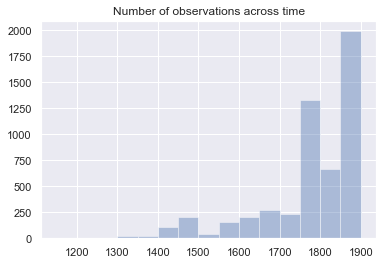

In [410]:
years_bins = range(1150,1901,50)

years = [hy["year"] for c in communes for hy in c["hab_year"] if hy["year"]<=1850]
print("min(years) = ", min(years))

print("Number of observations per year:")
print(pd.Series(years).value_counts(bins=years_bins,sort=False))

sns.distplot(years, bins=years_bins, kde=False, rug=False).set_title('Number of observations across time')

Text(0.5, 1.0, 'Number of communes with first observation before year Y')

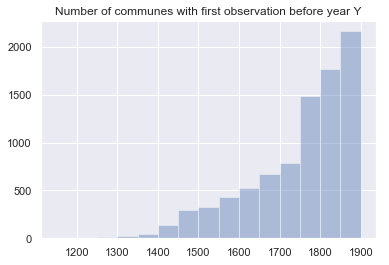

In [411]:


first_years = [min([y for hy in c["hab_year"] for y in [hy["year"]] if y<=1850]+[1850]) for c in communes ]

sns.distplot(first_years, bins=years_bins, hist_kws=dict(cumulative=True),kde=False,rug=False).set_title("Number of communes with first observation before year Y")

# Unit transformation

In [412]:
units = [hy["unit"]  for c in communes for hy in c["hab_year"] if hy["year"]<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

Number of each type of units:
Einw                                               2814
Feuerstätten                                        157
Haushalte                                           146
Feuerstellen                                         28
Häuser                                               25
Haushaltungen                                        23
Einw Kirchgem.                                       13
Steuerpflichtige                                     11
Einw. Kirchgem                                        6
Erwachsene                                            6
Einw Feuerschaukreis                                  6
Kanoniker                                             6
Hofstätten                                            4
Haushalt                                              3
Kommunikanten                                         3
Herdstellen                                           3
undefined                                             3
Herdstätten       

In [413]:
pd.Series(units).unique()

array(['Haushalte', 'Einw', 'Feuerstätten', 'Haushaltungen', 'Häuser',
       'Kirchgenossen', 'Steuerpflichtige', 'Erwachsenen',
       'Einw Feuerschaukreis', 'Erwachsene', 'Kanoniker', 'Höfe',
       'Herdstellen', 'Hofstätten', 'Pesttote', 'Fam', 'Kommunikanten',
       'Feuerstellen', 'Einw Kirchgem.', 'Juden', 'Einw outlier',
       'Feuerstätten (mit Sermuz, heute Gem', 'Bürger',
       '(Pfarrei einschliesslich Molondin und Vuissens)', 'Haushalt',
       'Einwohner', '', 'Hofgenossen', 'Hausväter', 'Einw Pedrinate',
       'Herdstätten', 'undefined', 'Beisassen', 'Einw. Kirchgem',
       'Haushalte Kirchgem'], dtype=object)

In [414]:
unit_einw_1 = ['Beisassen',
'Bürger',
'Einw',
'Einw Feuerschaukreis',
'Einw Kirchgem.',
'Einw. Kirchgem', 'Einwohner',
'Kirchgenossen', 'Kommunikanten'
]
unit_haushalte_5 = [
'Erwachsene', 'Erwachsenen', 'Fam', 'Feuerstellen', 'Feuerstätten',
'Feuerstätten (mit Sermuz, heute Gem', 'Haushalt', 'Haushalte',
'Haushalte Kirchgem', 'Haushaltungen', 'Hausväter', 'Herdstellen',
'Herdstätten', 'Hofgenossen', 'Hofstätten', 'Häuser', 'Höfe',
'Steuerpflichtige',
]
accepted_units = unit_einw_1+unit_haushalte_5

### Finding the conversion factor

In [415]:

def one1one5(a,b):
    return (a["unit"] in unit_einw_1 and b["unit"] in unit_haushalte_5) or (a["unit"] in unit_haushalte_5 and b["unit"] in unit_einw_1)

def detect_duplicated_years(commune):
    # create one dict with one entry per year
    # for each year:
    # - if no year in dict, add it
    # - if a year already there, add it to the list
    # filter the dict on the years where len()>1
    year_dict = {}
    for hy in commune["hab_year"]:
        if hy["year"] in year_dict:
            year_dict[hy["year"]].append(hy)
        else:
            year_dict[hy["year"]] = [hy]
    duplicates = {y:sorted(hys,key=lambda hy: -hy["pop"]) for y,hys in year_dict.items() if len(hys)>1}
    return duplicates

# find duplicates
duplicates = [(c["name"],c["canton"],y,hys) for c in communes for y,hys in (detect_duplicated_years(c)).items() if one1one5(hys[0],hys[1])]

dfduplicates = pd.DataFrame([{
    "commune": cname,
    "canton": canton,
    "year": y,
    "pop_einw": hys[0]["pop"],
    "pop_haus": hys[1]["pop"],
    "ratio": hys[0]["pop"] / hys[1]["pop"],
    "unit_haus": hys[1]["unit"]} for cname, canton, y, hys in duplicates])
dfduplicates = dfduplicates.sort_values(["year","unit_haus","commune"])
print("Number of double Haushaltungen-Einw data")
print(len(duplicates))
dfduplicates

Number of double Haushaltungen-Einw data
25


,canton,commune,pop_einw,pop_haus,ratio,unit_haus,year
23,BE,Bern,500,100,5.000000,Feuerstätten,1200
15,GE,Hermance,400,80,5.000000,Haushaltungen,1444
22,ZH,Regensdorf,97,23,4.217391,Haushaltungen,1468
18,SH,Neunkirch,460,92,5.000000,Häuser,1530
1,VD,Lutry,902,191,4.722513,Haushalte,1550
13,NE,Fresens,181,38,4.763158,Häuser,1632
20,NE,"Verrières, Les",570,114,5.000000,Haushalte,1664
12,LU,Altbüron,390,65,6.000000,Steuerpflichtige,1695
14,LU,Altishofen,430,72,5.972222,Steuerpflichtige,1695
24,AG,Windisch,402,77,5.220779,Haushaltungen,1736


In [416]:
def boxplot_condition(df, groupings, ax=plt):
    groupings = [(unit, f, f(dfduplicates)) for unit, f in groupings]
    ax.boxplot(
        [df.ratio.loc[condition] for unit, f, condition  in groupings],
        labels = [unit+f" ({np.sum(condition)}, mean: {np.round(np.mean(df.ratio.loc[condition]),2)})" for unit, f, condition in groupings]
        )
    #ax.xticks(rotation=10)
    ax.tick_params(labelrotation=10)

    

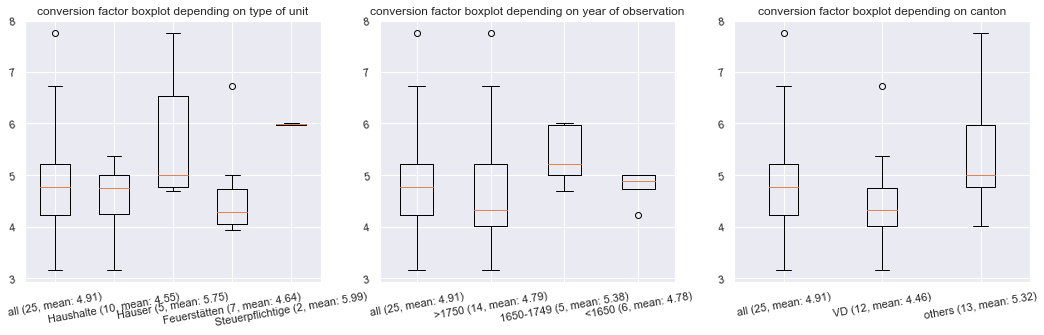

In [417]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4.8))

haus_units = [
    ("all", lambda df: df.pop_haus>0),
    ("Haushalte", lambda df: (df.unit_haus =="Haushaltungen") | (df.unit_haus=="Haushalte")),
    ("Häuser", lambda df: df.unit_haus=="Häuser"),
    ("Feuerstätten", lambda df: df.unit_haus=="Feuerstätten"),
    ("Steuerpflichtige", lambda df: df.unit_haus=="Steuerpflichtige")
]

haus_years= [
    ("all", lambda df: df.year>=0),
    (">1750", lambda df: df.year>1750),
    ("1650-1749", lambda df: (df.year>1650) & (df.year<=1750)),
    ("<1650", lambda df:  df.year<=1650),
]

haus_cantons = [
    ("all", lambda df: df.pop_haus>0),
    ("VD", lambda df: df.canton =="VD"),
    ("others", lambda df: df.canton !="VD"),
]

boxplot_condition(df, haus_units, ax1)
ax1.set_title("conversion factor boxplot depending on type of unit")
boxplot_condition(df, haus_years, ax2)
ax2.set_title("conversion factor boxplot depending on year of observation")
boxplot_condition(df, haus_cantons, ax3)
ax3.set_title("conversion factor boxplot depending on canton")
None

In [418]:
conversion_factor = np.mean(dfduplicates.ratio)
print(f"conversion factor: {np.round(conversion_factor,3)}")

conversion factor: 4.906


### Doing the conversion

Remove non-Einw data in duplicated years, as well as non-accepted units

In [419]:
for c in communes:
    duplicates = detect_duplicated_years(c)
    c["hab_year"] = [hy for hy in c["hab_year"] if hy["year"] not in duplicates or hy["unit"]=="Einw"]
    c["hab_year"] = [hy for hy in c["hab_year"] if hy["unit"] in accepted_units]

In [420]:
for c in communes:
    to_delete = []
    #print(c["hab_year"])
    for i,hy in enumerate(c["hab_year"]):
        if hy["unit"] in unit_haushalte_5:
            hy["original_unit"] = hy["unit"]
            hy["einw_conversion_factor"] = conversion_factor
            hy["pop"] = int(np.round(conversion_factor*hy["pop"]))
        hy["unit"] = "Einw"    
    

In [428]:
c = communes[1]
duplicates = detect_duplicated_years(c)
duplicates
c

{'name': 'Lutry',
 'canton': 'VD',
 'url': '/Articles/002420/?language=de',
 'firstmention': 908,
 'hab_year': [{'year': 1850, 'pop': 2011, 'unit': 'Einw'},
  {'year': 1900, 'pop': 2243, 'unit': 'Einw'},
  {'year': 1950, 'pop': 2916, 'unit': 'Einw'},
  {'year': 1980, 'pop': 5884, 'unit': 'Einw'},
  {'year': 2000, 'pop': 8270, 'unit': 'Einw'},
  {'year': 1416,
   'pop': 981,
   'unit': 'Einw',
   'original_unit': 'Haushalte',
   'einw_conversion_factor': 4.906486226243853},
  {'year': 1798, 'pop': 2433, 'unit': 'Einw'},
  {'year': 1550, 'pop': 902, 'unit': 'Einw'},
  {'year': 1764, 'pop': 1780, 'unit': 'Einw'}],
 'notes': 'hab+foyer data!, with or without Savigny, ',
 'raw_hab_year': [{'year': 1850, 'pop': 2011, 'unit': 'Einw'},
  {'year': 1900, 'pop': 2243, 'unit': 'Einw'},
  {'year': 1950, 'pop': 2916, 'unit': 'Einw'},
  {'year': 1980, 'pop': 5884, 'unit': 'Einw'},
  {'year': 2000, 'pop': 8270, 'unit': 'Einw'},
  {'year': 1416, 'pop': 200, 'unit': 'Haushalte'},
  {'year': 1550, 'pop':

In [422]:
[hy for hy in c["hab_year"] if hy["year"] not in duplicates or hy["unit"]=="Einw"]

[{'year': 1850, 'pop': 2011, 'unit': 'Einw'},
 {'year': 1900, 'pop': 2243, 'unit': 'Einw'},
 {'year': 1950, 'pop': 2916, 'unit': 'Einw'},
 {'year': 1980, 'pop': 5884, 'unit': 'Einw'},
 {'year': 2000, 'pop': 8270, 'unit': 'Einw'},
 {'year': 1416,
  'pop': 981,
  'unit': 'Einw',
  'original_unit': 'Haushalte',
  'einw_conversion_factor': 4.906486226243853},
 {'year': 1798, 'pop': 2433, 'unit': 'Einw'},
 {'year': 1550, 'pop': 902, 'unit': 'Einw'},
 {'year': 1764, 'pop': 1780, 'unit': 'Einw'}]

In [423]:
units = [hy["unit"]  for c in communes for hy in c["hab_year"] if hy["year"]<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

Number of each type of units:
Einw    3230
dtype: int64


In [424]:
dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
dfcommunes

,name,canton,url,firstmention,hab_year,raw_hab_year,notes
0,Château-d'Œx,VD,/Articles/002593/?language=de,1080,"[{'year': 1416, 'pop': 589, 'unit': 'Einw', 'o...","[{'year': 1416, 'pop': 120, 'unit': 'Haushalte...","hab+foyer data!, unclear population count (wit..."
1,Lutry,VD,/Articles/002420/?language=de,908,"[{'year': 1850, 'pop': 2011, 'unit': 'Einw'}, ...","[{'year': 1850, 'pop': 2011, 'unit': 'Einw'}, ...","hab+foyer data!, with or without Savigny,"
2,Ballaigues,VD,/Articles/002528/?language=de,1228,"[{'year': 1416, 'pop': 49, 'unit': 'Einw', 'or...","[{'year': 1416, 'pop': 10, 'unit': 'Haushalte'...","hab+foyer data!,"
3,Belmont-sur-Yverdon,VD,/Articles/002623/?language=de,1154,"[{'year': 1409, 'pop': 152, 'unit': 'Einw', 'o...","[{'year': 1409, 'pop': 31, 'unit': 'Haushalte'...","hab+foyer data!,"
4,Borex,VD,/Articles/002498/?language=de,1135,"[{'year': 1429, 'pop': 69, 'unit': 'Einw', 'or...","[{'year': 1429, 'pop': 14, 'unit': 'Feuerstätt...","hab+foyer data!,"
5,Ependes (VD),VD,/Articles/002635/?language=de,1154,"[{'year': 1404, 'pop': 83, 'unit': 'Einw', 'or...","[{'year': 1404, 'pop': 17, 'unit': 'Haushalte'...","hab+foyer data!,"
6,Lignerolle,VD,/Articles/002538/?language=de,1160,"[{'year': 1416, 'pop': 294, 'unit': 'Einw', 'o...","[{'year': 1416, 'pop': 60, 'unit': 'Feuerstätt...","hab+foyer data!,"
7,Premier,VD,/Articles/002542/?language=de,1316,"[{'year': 1396, 'pop': 74, 'unit': 'Einw', 'or...","[{'year': 1396, 'pop': 15, 'unit': 'Feuerstätt...","hab+foyer data!,"
8,Pully,VD,/Articles/002412/?language=de,994,"[{'year': 1764, 'pop': 626, 'unit': 'Einw'}, {...","[{'year': 1764, 'pop': 626, 'unit': 'Einw'}, {...","hab+foyer data!,"
9,Suchy,VD,/Articles/002650/?language=de,885,"[{'year': 1409, 'pop': 118, 'unit': 'Einw', 'o...","[{'year': 1409, 'pop': 24, 'unit': 'Feuerstätt...","hab+foyer data!,"


In [425]:
dfcommunes.to_csv("communes_units_converted.csv", sep=";")

In [426]:
with open('communes_units_converted.json', 'w') as json_file:
  json.dump(communes, json_file)

In [427]:
communes[0]

{'name': "Château-d'Œx",
 'canton': 'VD',
 'url': '/Articles/002593/?language=de',
 'firstmention': 1080,
 'hab_year': [{'year': 1416,
   'pop': 589,
   'unit': 'Einw',
   'original_unit': 'Haushalte',
   'einw_conversion_factor': 4.906486226243853},
  {'year': 1764, 'pop': 1751, 'unit': 'Einw'},
  {'year': 1803, 'pop': 2001, 'unit': 'Einw'},
  {'year': 1850, 'pop': 2054, 'unit': 'Einw'},
  {'year': 1900, 'pop': 3025, 'unit': 'Einw'},
  {'year': 1930, 'pop': 3840, 'unit': 'Einw'},
  {'year': 1950, 'pop': 3381, 'unit': 'Einw'},
  {'year': 1980, 'pop': 2872, 'unit': 'Einw'},
  {'year': 1990, 'pop': 3110, 'unit': 'Einw'},
  {'year': 2000, 'pop': 2949, 'unit': 'Einw'}],
 'notes': "hab+foyer data!, unclear population count (with or without l'etivaz), ",
 'raw_hab_year': [{'year': 1416, 'pop': 120, 'unit': 'Haushalte'},
  {'year': 1764, 'pop': 1751, 'unit': 'Einw'},
  {'year': 1803, 'pop': 2001, 'unit': 'Einw'},
  {'year': 1850, 'pop': 2054, 'unit': 'Einw'},
  {'year': 1900, 'pop': 3025, 'un

# Doing the interpolation

Create an interpolator per commune:

In [34]:
def create_interpolator(data_points):
    """Returns a linear interpolator from the given dataPoints
    @param {*} dataPoints an array of length 2 arrays, each sub-array is a coordinate with sub-array[0]=x, sub-array[1]=y
    @returns interpolate(x) a function taking a value x and returning the linear interpolation of y at x, or null if x is outside the x range of dataPoints
    """
    data_points = sorted(data_points, key=lambda hy:hy[0])
    def interpolate(x):
        indices = [i for i in range(len(data_points)) if data_points[i][0]>=x]
        print(indices)
        if len(indices)>0:
            if indices[0]==0:
                return data_points[indices[0]][1]
            else:
                i = indices[0]
                a = data_points[i-1]
                b = data_points[i]
                return a[1]+ (b[1]-a[1])/(b[0]-a[0]) * (x-a[0])
        return None
    return interpolate
    

In [35]:
a = [(0,0),(1,1),(2,3),(3,6)]

In [36]:
interp = create_interpolator(a)

In [44]:
interp(3)

[3]


6.0